In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Reshape,LeakyReLU,Dropout,Conv2DTranspose, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input,UpSampling2D,Activation )
from tensorflow.keras.optimizers import Adam

# Data

## Download Data

In [ ]:
!pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d badasstechie/celebahq-resized-256x256
!unzip "/content/celebahq-resized-256x256.zip" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/celeba_hq_256/25000.jpg  
  inflating: /content/dataset/celeba_hq_256/25001.jpg  
  inflating: /content/dataset/celeba_hq_256/25002.jpg  
  inflating: /content/dataset/celeba_hq_256/25003.jpg  
  inflating: /content/dataset/celeba_hq_256/25004.jpg  
  inflating: /content/dataset/celeba_hq_256/25005.jpg  
  inflating: /content/dataset/celeba_hq_256/25006.jpg  
  inflating: /content/dataset/celeba_hq_256/25007.jpg  
  inflating: /content/dataset/celeba_hq_256/25008.jpg  
  inflating: /content/dataset/celeba_hq_256/25009.jpg  
  inflating: /content/dataset/celeba_hq_256/25010.jpg  
  inflating: /content/dataset/celeba_hq_256/25011.jpg  
  inflating: /content/dataset/celeba_hq_256/25012.jpg  
  inflating: /content/dataset/celeba_hq_256/25013.jpg  
  inflating: /content/dataset/celeba_hq_256/25014.jpg  
  inflating: /content/dataset/celeba_hq_256/25015.jpg  
  inflating: /content/dataset/celeba_hq_256/25016.jpg

In [ ]:
# !pip install -q kaggle
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# !chmod 600 /root/.kaggle/kaggle.json
# !kaggle datasets download -d jessicali9530/celeba-dataset
# !unzip "/content/celeba-dataset.zip" -d "/content/dataset/"

## Prepare Data

In [ ]:
BATCH_SIZE = 128
IM_SHAPE = (64,64,3)
LEARNING_RATE = 1e-4
LATENT_DIM=100
EPOCHS=20

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/dataset/celeba_hq_256", label_mode=None, image_size=(IM_SHAPE[0], IM_SHAPE[1]), batch_size=BATCH_SIZE
)

Found 30000 files.


In [ ]:
dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

In [ ]:
def preprocess(image):
  return tf.cast(image, tf.float32) / 127.5 - 1.0

In [ ]:
train_dataset = (
    dataset
    .map(preprocess)
    .unbatch()
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .batch(BATCH_SIZE,drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
for d in train_dataset.take(1):
  print(d.shape)

(128, 64, 64, 3)


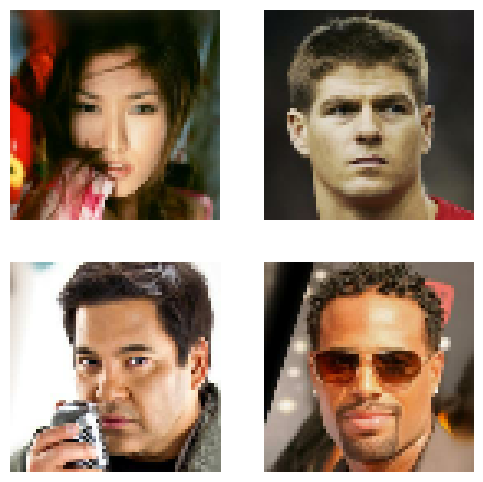

In [ ]:
plt.figure(figsize = (6,6))
k=0
n = 4
for i in range(n):
  ax = plt.subplot(2,2, k+1)
  plt.imshow((d[i]+1)/2)
  plt.axis("off")
  k+=1

# MOdeling

In [ ]:
generator=tf.keras.Sequential([
  Input(shape=(LATENT_DIM,)),
  Dense(4*4*LATENT_DIM),
  Reshape((4,4,LATENT_DIM)),

  Conv2DTranspose(512,kernel_size=4,strides=2, padding='same'),
  BatchNormalization(),
  LeakyReLU(0.2),

  Conv2DTranspose(256,kernel_size=4,strides=2, padding='same'),
  BatchNormalization(),
  LeakyReLU(0.2),

  Conv2DTranspose(128,kernel_size=4,strides=2, padding='same'),
  BatchNormalization(),
  LeakyReLU(0.2),

  Conv2DTranspose(3,kernel_size=4,strides=2, activation=tf.keras.activations.tanh, padding='same'),

],name='generator')
generator.summary()


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1600)                │         161,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 4, 100)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 8, 8, 512)           │         819,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 8, 8, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 16, 16, 256)         │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 128)         │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 64, 64, 3)           │           6,147 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,612,867 (13.78 MB)

 Trainable params: 3,611,075 (13.78 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [ ]:
discriminator=tf.keras.Sequential([
  Input(shape=(IM_SHAPE[0],IM_SHAPE[1],3)),

  Conv2D(64,kernel_size=4,strides=2, padding='same'),
  LeakyReLU(0.2),

  Conv2D(128,kernel_size=4,strides=2, padding='same'),
  LeakyReLU(0.2),

  Conv2D(256,kernel_size=4,strides=2, padding='same'),
  LeakyReLU(0.2),

  Conv2D(512,kernel_size=4,strides=2, padding='same'),
  LeakyReLU(0.2),

  Conv2D(1,kernel_size=4,strides=2, padding='same'),

  Flatten(),
  Dense(1,)


],name='discriminator')

In [ ]:
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 512)           │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 2, 2, 1)             │           8,193 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,764,742 (10.55 MB)

 Trainable params: 2,764,742 (10.55 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class ShowImage(tf.keras.callbacks.Callback):
    def __init__(self, latent_dim=100):
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        n=6
        k=0
        out=self.model.generator(tf.random.normal(shape=(36, self.latent_dim)))
        plt.figure(figsize=(16,16))
        for i in range(n):
          for j in range(n):
            ax=plt.subplot(n,n,k+1)
            plt.imshow((out[k]+1)/2,)
            plt.axis('off')
            k+=1
        plt.savefig("generated/gen_images_epoch_{}.png".format(epoch+1))

In [ ]:
def discriminator_loss(real_predictions, fake_predictions):
    real_loss = tf.reduce_mean(real_predictions)
    fake_loss = tf.reduce_mean(fake_predictions)
    return fake_loss - real_loss

In [ ]:
def generator_loss(fake_predictions):
    return -tf.reduce_mean(fake_predictions)

In [ ]:
class WGAN(tf.keras.Model):
  def __init__(self,discriminator,generator):
    super(WGAN,self).__init__()
    self.discriminator=discriminator
    self.generator=generator

  def compile(self,d_optimizer,g_optimizer,d_loss_fn,g_loss_fn,n_critic,lamda):
    super(WGAN,self).compile()
    self.d_optimizer=d_optimizer
    self.g_optimizer=g_optimizer
    self.d_loss_fn=d_loss_fn
    self.g_loss_fn=g_loss_fn
    self.n_critic=n_critic
    self.lamda=lamda
    self.d_loss_metric=tf.keras.metrics.Mean(name='d_loss')
    self.g_loss_metric=tf.keras.metrics.Mean(name='g_loss')

  @property
  def metrics(self):
    return [self.d_loss_metric,self.g_loss_metric]

  def gradient_penalty(self,batch_size,real_images,fake_images):
    epsilon=tf.random.normal([batch_size,1,1,1],0.0,1.0)
    interpolation=epsilon*real_images+(1-epsilon)*fake_images

    with tf.GradientTape() as gp_tape:
      gp_tape.watch(interpolation)
      prediction=self.discriminator(interpolation,training=True)
    grads=gp_tape.gradient(prediction,interpolation)
    l2_norm=tf.sqrt(tf.reduce_sum(tf.square(grads),axis=[1,2,3]))
    return tf.reduce_mean((l2_norm-1)**2)

  def train_step(self,real_images):
    batch_size=tf.shape(real_images)[0]

    ######## Discriminator
    for _ in range(self.n_critic):
      random_noise=tf.random.normal(shape=(batch_size,LATENT_DIM))
      fake_images=self.generator(random_noise)

      with tf.GradientTape() as recorder:
        real_predictions=self.discriminator(real_images)
        fake_predictions=self.discriminator(fake_images)
        d_loss=self.d_loss_fn(real_predictions,fake_predictions)

        d_loss+=self.lamda*self.gradient_penalty(batch_size,real_images,fake_images)

      partial_derivatives = recorder.gradient(d_loss,self.discriminator.trainable_weights)
      self.d_optimizer.apply_gradients(zip(partial_derivatives, self.discriminator.trainable_weights))

    ############# Generator
    random_noise=tf.random.normal(shape=(batch_size,LATENT_DIM))
    with tf.GradientTape() as recorder:

      fake_predictions=self.discriminator(self.generator(random_noise))
      g_loss=self.g_loss_fn(fake_predictions)

    partial_derivatives = recorder.gradient(g_loss,self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(zip(partial_derivatives, self.generator.trainable_weights))

    self.d_loss_metric.update_state(d_loss)
    self.g_loss_metric.update_state(g_loss)

    return {'d_loss':self.d_loss_metric.result(),
            'g_loss':self.g_loss_metric.result()}

In [ ]:
wgan=WGAN(discriminator,generator)
wgan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5, beta_2=0.9),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5, beta_2=0.9),
    d_loss_fn=discriminator_loss,
    g_loss_fn=generator_loss,
    n_critic=5,
    lamda=10,
)

In [ ]:
!mkdir generated

In [ ]:
history=wgan.fit(train_dataset,epochs=EPOCHS,callbacks=[ShowImage(LATENT_DIM)])

Epoch 1/20
    234/Unknown 245s 898ms/step - d_loss: -97.8924 - g_loss: -15.4741

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


234/234 ━━━━━━━━━━━━━━━━━━━━ 247s 906ms/step - d_loss: -97.8004 - g_loss: -15.5115
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 215s 917ms/step - d_loss: -28.1334 - g_loss: -29.5126
Epoch 3/20
101/234 ━━━━━━━━━━━━━━━━━━━━ 2:01 911ms/step - d_loss: -24.0553 - g_loss: -16.6553

In [ ]:
plt.plot(history.history['d_loss'])
plt.plot(history.history['g_loss'])
plt.title('GAN Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['d_loss', 'g_loss'], loc='upper left')
plt.show()

In [ ]:
history=wgan.fit(train_dataset,epochs=50,callbacks=[ShowImage(LATENT_DIM)])

In [ ]:
x = tf.random.uniform([32,64,64,3],0,1)#constant(3.0)
with tf.GradientTape() as g:
  g.watch(x)
  y = x * x
dy_dx = g.gradient(y, x)
print(dy_dx.shape)